In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from termcolor import colored

# Model
# --------------------------------------------------------------------
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.neighbors import NearestNeighbors, KNeighborsClassifier
from sklearn import metrics

# Importar datos Puros Tratados

In [4]:
data = pd.read_csv('./dataA.csv')
data.head(4)

,Netflows,p1_d,p2_d,p3_d,duration,max_d,min_d,#packets,Avg_bps,Avg_pps,...,First_Protocol_TCP,First_Protocol_UDP,Type_mine,Type_not_mine,Cryptocurrency_Bitcash,Cryptocurrency_Bitcoin,Cryptocurrency_Does not have,Cryptocurrency_Etherium,Cryptocurrency_Litecoin,Cryptocurrency_Monero
0,1.575318,-0.700949,-0.804477,-0.909496,0.054551,-0.864733,-0.625504,0.570941,1.236305,1.285332,...,1,0,0,1,0,0,1,0,0,0
1,-0.272723,-0.700949,-0.804477,-0.960618,-0.488545,-1.268557,-0.625504,-0.368003,-0.359170,-0.336093,...,0,1,0,1,0,0,1,0,0,0
2,0.473802,-0.159640,-0.240996,-0.196315,2.054728,-0.241926,-0.625504,-0.241532,-0.353254,-0.252227,...,1,0,0,1,0,0,1,0,0,0
3,-0.486762,-0.569563,-0.669158,0.418280,-0.420426,0.234577,-0.625504,-0.367723,-0.362821,-0.392005,...,1,0,1,0,0,1,0,0,0,0


# Mejores Caracteristicas

In [5]:
feature_selection = ['#dp', '#sp', 'Avg_bpp', 'first_dp', 'first_sp', 'min_d', 'p1_d',
       'p1_ip', 'p2_d', 'p2_ib', 'p2_ip', 'p3_ib', 'second_dp',
       'second_sp']

# Modelo

### Holdout

In [6]:
y = data['Type_mine']
X = data[feature_selection]

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X,y,train_size = 0.7, test_size=0.3, random_state = 1234)

### KNN

In [8]:
k_vec = np.arange(1,40,2)
vec_train = []
vec_test =[]

for k in k_vec:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_train)
    vec_train.append(metrics.accuracy_score(y_train, y_pred))
    y_pred = knn.predict(X_test)
    vec_test.append(metrics.accuracy_score(y_test, y_pred))
v = pd.DataFrame()
v['K'] = k_vec
v['vec_train'] = vec_train
v['vec_test'] = vec_test
display(v)

,K,vec_train,vec_test
0,1,1.000000,0.999296
1,3,0.998793,0.998592
2,5,0.997585,0.998592
3,7,0.997585,0.997887
4,9,0.996076,0.997183
5,11,0.994869,0.997183
6,13,0.994567,0.997183
7,15,0.994567,0.997183
8,17,0.994265,0.997183
9,19,0.995171,0.996479


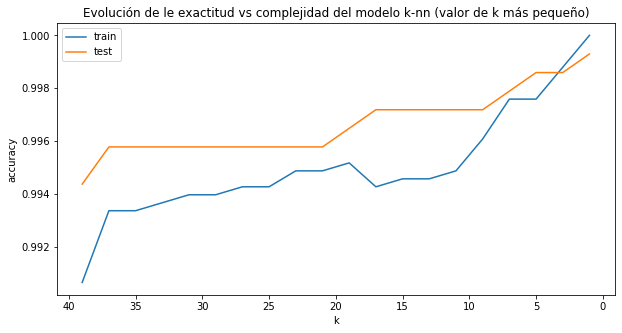

In [9]:
plt.figure(figsize=(10,5))
ax = plt.gca()
plt.plot(k_vec, vec_train)
plt.plot(k_vec, vec_test)
ax.set_xlim(ax.get_xlim()[::-1])
plt.axis('tight')
plt.xlabel('k')
plt.ylabel('accuracy')
plt.title('Evolución de le exactitud vs complejidad del modelo k-nn (valor de k más pequeño)')
plt.legend(['train', 'test'])

In [10]:
k_best = 4

In [11]:
knn = KNeighborsClassifier(n_neighbors=k_best)
knn.fit(X_train,y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='uniform')

In [12]:
y_pred = knn.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 1], dtype=int64)

### Evaluación del modelo

In [13]:
y_test.shape, y_pred.shape

((1420,), (1420,))

([<matplotlib.axis.YTick at 0x1484cf10a58>,
 <a list of 2 Text yticklabel objects>)

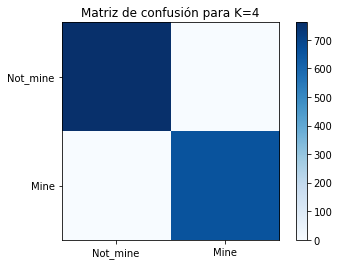

In [14]:
churm = metrics.confusion_matrix(y_test, y_pred)
plt.imshow(churm, cmap=plt.cm.Blues)
plt.title(f"Matriz de confusión para K={k_best}")
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['Not_mine','Mine'])
plt.yticks(tick_marks, ['Not_mine','Mine'])

In [15]:
pd.DataFrame(churm)

,0,1
0,761,2
1,0,657


In [16]:
print("Exactitud: ", metrics.accuracy_score(y_test, y_pred))
print("Kappa: ", metrics.cohen_kappa_score(y_test, y_pred))

Exactitud:  0.9985915492957746
Kappa:  0.997167912851493


In [17]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[1], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[1], average='macro'))

VP = np.sum(churm[1:2,1:2])
FN = np.sum(churm[1,0:1])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[1], average='macro'))


Precisión     :  0.9969650986342944
Recall        :  1.0
Especificidad :  1.0
F1-score      :  0.9984802431610942


In [18]:
print("Precisión     : ", metrics.precision_score(y_test, y_pred, labels=[0], average='macro'))
print("Recall        : ", metrics.recall_score(y_test, y_pred, labels=[0], average='macro'))

VP = np.sum(churm[0:1,0:1])
FN = np.sum(churm[0,1:2])
specificity = VP/(VP+FN)

print("Especificidad : ", specificity)

print("F1-score      : ", metrics.f1_score(y_test, y_pred, labels=[0], average='macro'))

Precisión     :  1.0
Recall        :  0.9973787680209698
Especificidad :  0.9973787680209698
F1-score      :  0.9986876640419947


# Curva ROC

In [21]:
y_pred_proba = knn.predict_proba(X_test)

In [22]:
lr_probs = y_pred_proba[:,1]

In [23]:
ns_probs = [0 for _ in range(len(y_test))]

In [24]:
ns_auc = metrics.roc_auc_score(y_test, ns_probs)
ns_auc

0.5

In [25]:
lr_auc = metrics.roc_auc_score(y_test, lr_probs)
lr_auc

0.9993446920052425

In [26]:
#Sumo los scores
print('No Skill: ROC AUC=%.3f' % (ns_auc))
print('KNN: ROC AUC=%.3f' % (lr_auc))

No Skill: ROC AUC=0.500
KNN: ROC AUC=0.999


In [27]:
ns_fpr, ns_tpr, thresholds  = metrics.roc_curve(y_test,ns_probs)
lr_fpr, lr_tpr, thresholds = metrics.roc_curve(y_test, lr_probs)

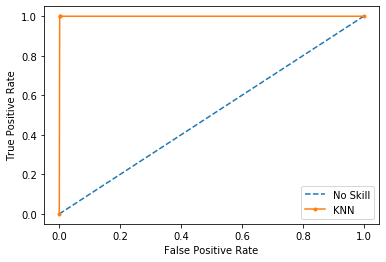

In [28]:
#Plot la roc curva para el modelo
plt.plot(ns_fpr,ns_tpr,linestyle='--', label='No Skill')
plt.plot(lr_fpr, lr_tpr, marker='.', label='KNN')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
plt.show()